In [1]:
%load_ext autoreload
%autoreload 2
import dgl
import torch
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MAtrices de Correlacion

## MAtriz correlacion Todos los atributos

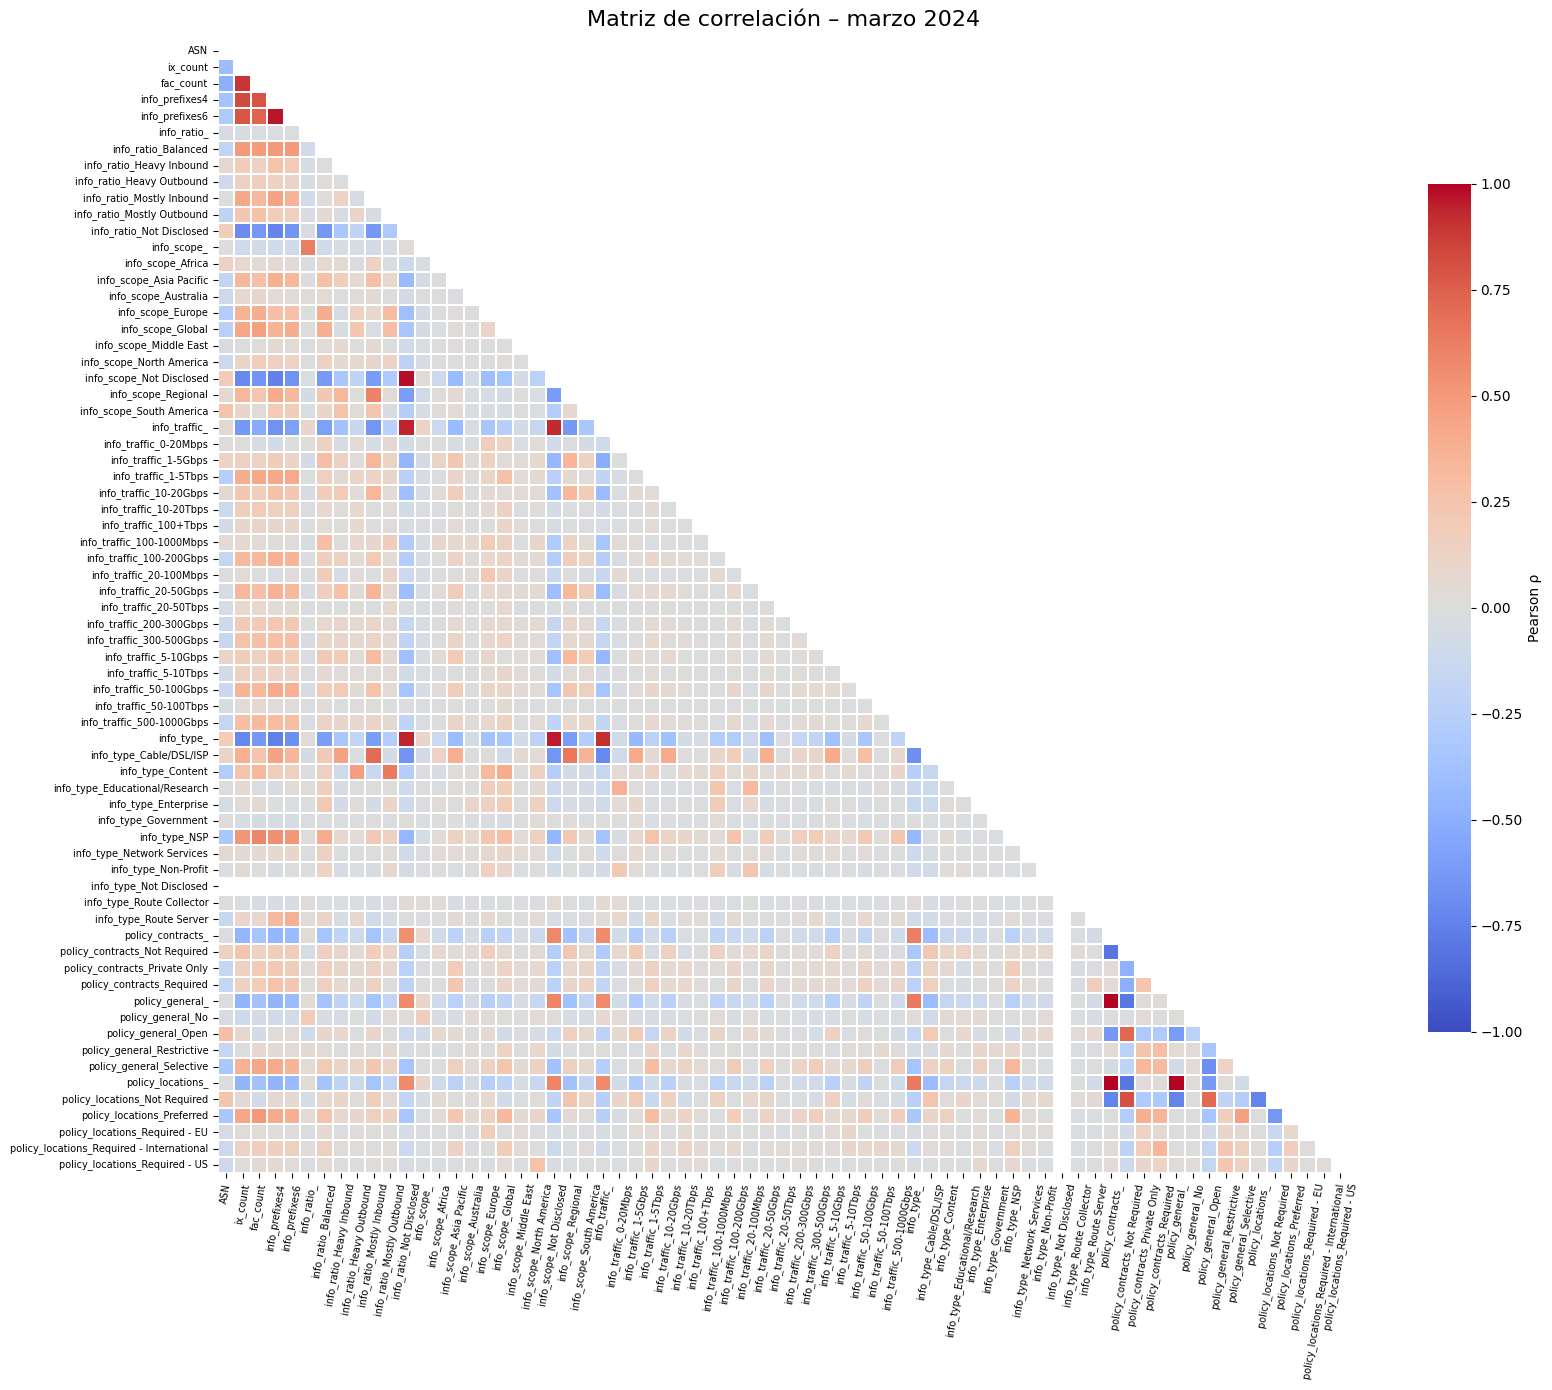

In [49]:
data_path = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/' 
corr_method = 'pearson' 
thr = 0.50                   # umbral de “fuerte” correlación
df_febrero = pd.read_csv(data_path + 'node_features_mio_febrero.csv')
corr_febrero = df_febrero.corr(method="pearson")      # o "spearman"
# # 4) Dibuja (opción A: heatmap rápido en Seaborn)
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_febrero, cmap="coolwarm", vmin=-1, vmax=1,
#             square=True, linewidths=.3,
#             cbar_kws={"label": "Pearson ρ"},
#             xticklabels=True, yticklabels=True)
# plt.title("Matriz de correlación de atributos (marzo 2024)")
# plt.xticks(rotation=90, fontsize=6)
# plt.yticks(fontsize=6)
# plt.tight_layout()
# plt.show()


corr = corr_febrero.corr(method='pearson')

# -----  mascarilla para quedarnos con la parte inferior  -----
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(18, 14))          # ➊  tamaño grande
sns.heatmap(
    corr, mask=mask,
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    square=True, linewidths=.2,
    cbar_kws={'label': "Pearson ρ", 'shrink': .75},   # ➋  barra más pequeña
    xticklabels=True, yticklabels=True
)

ax.set_title("Matriz de correlación – marzo 2024", fontsize=16, pad=12)
ax.tick_params(axis='x', labelrotation=80, labelsize=7)  # ➌ etiquetas inclinadas
ax.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()


Pares con |ρ| ≥ 0.5  (Pearson)
                         Var1                          Var2       rho
            policy_locations_               policy_general_  0.999613
              policy_general_             policy_contracts_  0.958264
            policy_locations_             policy_contracts_  0.957890
               info_prefixes6                info_prefixes4  0.804335
     info_scope_Not Disclosed      info_ratio_Not Disclosed  0.760903
                info_traffic_      info_ratio_Not Disclosed  0.683179
                   info_type_      info_scope_Not Disclosed  0.670734
                   info_type_      info_ratio_Not Disclosed  0.630232
                info_traffic_      info_scope_Not Disclosed  0.615704
                    fac_count                      ix_count  0.554459
                   info_type_                 info_traffic_  0.553895
policy_locations_Not Required policy_contracts_Not Required  0.516859
    policy_contracts_Required policy_contracts_Not Require

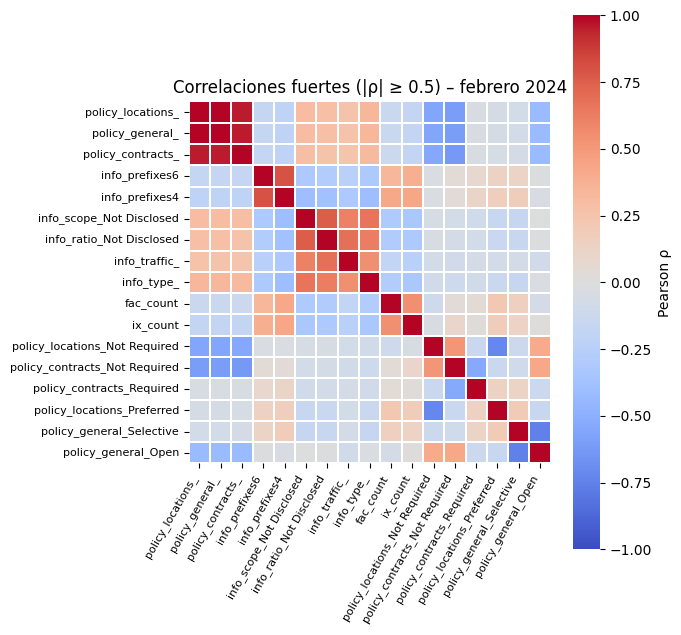

In [46]:
# 3) Extraer correlaciones fuertes (solo triángulo inferior para no duplicar)
mask_lower = np.tril(np.ones_like(corr, dtype=bool), k=-1)
corr_strong = (
    corr_febrero.where(mask_lower)
        .stack()                                # (col1,col2,rho)
        .reset_index()
        .rename(columns={'level_0':'Var1','level_1':'Var2',0:'rho'})
        .query('abs(rho) >= @thr')              # |ρ| ≥ umbral
        .sort_values('rho', ascending=False)
)

print(f"\nPares con |ρ| ≥ {thr}  ({corr_method.title()})")
print(corr_strong.to_string(index=False))



# 4) Columnas únicas involucradas en correlaciones fuertes
cols_strong = pd.unique(corr_strong[['Var1','Var2']].values.ravel())

# 5) Heat-map solo con esas columnas
plt.figure(figsize=(max(6, 0.4*len(cols_strong)), max(4, 0.4*len(cols_strong))))
sns.heatmap(
    corr_febrero.loc[cols_strong, cols_strong],
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    square=True, linewidths=.3,
    cbar_kws={'label': f'{corr_method.title()} ρ'},
    xticklabels=True, yticklabels=True
)
plt.title(f'Correlaciones fuertes (|ρ| ≥ {thr}) – febrero 2024')
plt.xticks(rotation=60, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


## Matriz correlacion atributos numericos

In [22]:
# Correlacion entre los atributos numericos
num_cols = ['ASN', 'ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']
df_num   = df_febrero[num_cols]
df_num

,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6
0,3,0.0,0.164753,0.173565,0.057027
1,4,0.0,0.000000,0.000000,0.000000
2,6,0.0,0.000000,0.000000,0.000000
3,7,0.0,0.000000,0.000000,0.000000
4,8,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...
29413,400863,0.0,0.103948,0.100343,0.000000
29414,400917,0.0,0.000000,0.334054,0.511453
29415,400919,0.0,0.103948,0.079520,0.180770
29416,401307,0.0,0.000000,0.000000,0.000000


In [24]:
corr_num = df_num.corr(method="pearson")      # o "spearman"
corr_num

,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6
ASN,1.000000,-0.170568,-0.226797,-0.167041,-0.056282
ix_count,-0.170568,1.000000,0.554459,0.432766,0.388054
fac_count,-0.226797,0.554459,1.000000,0.423475,0.339527
info_prefixes4,-0.167041,0.432766,0.423475,1.000000,0.804335
info_prefixes6,-0.056282,0.388054,0.339527,0.804335,1.000000


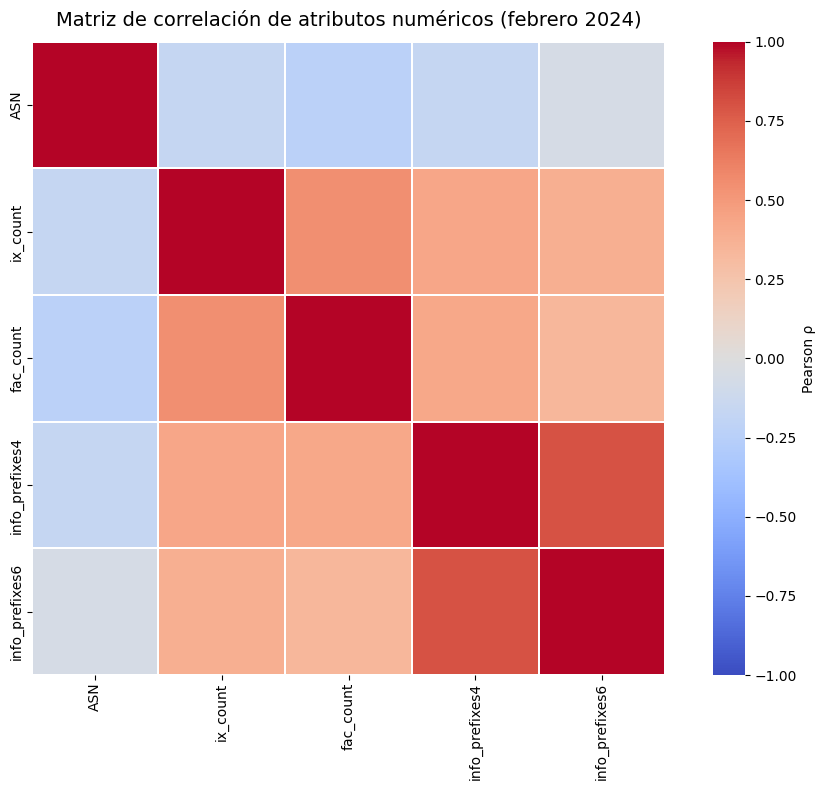

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    corr_num,
    cmap="coolwarm", vmin=-1, vmax=1,
    square=True, linewidths=.3,
    cbar_kws={"label": "Pearson ρ"},
    xticklabels=True, yticklabels=True,
    ax=ax                       # <-- usa el mismo axes
)

ax.set_title("Matriz de correlación de atributos numéricos (febrero 2024)",
             fontsize=14, pad=12)

# Ajusta los ticks **después** de dibujar
ax.set_xticklabels(ax.get_xticklabels(),
                   fontsize=10,     # tamaño que quieras
                   rotation=90,
                   ha='center')     # centrado horizontal
ax.set_yticklabels(ax.get_yticklabels(),
                   fontsize=10)

# (opcional) más separación entre etiquetas y eje
ax.tick_params(axis='x', pad=2)     # pad en puntos
ax.tick_params(axis='y', pad=2)

plt.tight_layout()
plt.show()



## Matriz de correlacion Previo

In [29]:
data_path = '/media/valentina/KINGSTON/TESIS/InternetGNNData2022/node_features.csv'
df_2022 = pd.read_csv(data_path)
df_2022

,ASN,AS_rank_numberAsns,AS_rank_numberPrefixes,AS_rank_numberAddresses,AS_rank_total,AS_rank_customer,AS_rank_peer,AS_rank_provider,peeringDB_ix_count,peeringDB_fac_count,...,ASDB_C1L1_Health Care Services,ASDB_C1L1_Manufacturing,"ASDB_C1L1_Media, Publishing, and Broadcasting","ASDB_C1L1_Museums, Libraries, and Entertainment",ASDB_C1L1_None,ASDB_C1L1_Other,"ASDB_C1L1_Retail Stores, Wholesale, and E-commerce Sites",ASDB_C1L1_Service,ASDB_C1L1_Travel and Accommodation,ASDB_C1L1_Utilities (Excluding Internet Service)
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.108750,0.367823,0.456519,0.315402,0.183297,0.155328,0.489582,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.159316,0.453620,0.565342,0.346794,0.125120,0.246190,0.538821,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000000,0.367307,0.676835,0.346794,0.000000,0.123095,0.631103,0.0,0.165327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.000000,0.281737,0.516589,0.261662,0.000000,0.000000,0.489582,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115572,4294901890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115573,4294901891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115574,4294901924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115575,4294901928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# 3) Calcula la matriz.  Pearson es el default.
corr_2022 = df_2022.corr(method="pearson")      # o "spearman"
corr_2022

,ASN,AS_rank_numberAsns,AS_rank_numberPrefixes,AS_rank_numberAddresses,AS_rank_total,AS_rank_customer,AS_rank_peer,AS_rank_provider,peeringDB_ix_count,peeringDB_fac_count,...,ASDB_C1L1_Health Care Services,ASDB_C1L1_Manufacturing,"ASDB_C1L1_Media, Publishing, and Broadcasting","ASDB_C1L1_Museums, Libraries, and Entertainment",ASDB_C1L1_None,ASDB_C1L1_Other,"ASDB_C1L1_Retail Stores, Wholesale, and E-commerce Sites",ASDB_C1L1_Service,ASDB_C1L1_Travel and Accommodation,ASDB_C1L1_Utilities (Excluding Internet Service)
ASN,1.000000,-0.023359,-0.017772,-0.062126,-0.089223,-0.026456,-0.030262,-0.116679,-0.197300,-0.246384,...,-0.018668,-0.016124,-0.009571,0.011277,0.013764,0.033380,0.041197,-0.000198,-0.001521,0.004909
AS_rank_numberAsns,-0.023359,1.000000,0.693701,0.417263,0.626069,0.969940,0.521634,0.287297,0.419326,0.426168,...,0.007943,0.005786,-0.001763,-0.001024,-0.004047,0.000302,-0.005530,0.002912,-0.009818,-0.002083
AS_rank_numberPrefixes,-0.017772,0.693701,1.000000,0.827283,0.774057,0.706234,0.490322,0.664712,0.399769,0.391042,...,0.009069,0.006242,-0.002796,-0.001758,-0.004775,-0.003709,0.000373,0.004672,-0.011304,0.001995
AS_rank_numberAddresses,-0.062126,0.417263,0.827283,1.000000,0.765478,0.440135,0.370273,0.837568,0.337845,0.323275,...,0.006015,0.000854,-0.003971,0.002597,-0.001432,-0.007877,0.004234,0.002483,-0.006250,0.002747
AS_rank_total,-0.089223,0.626069,0.774057,0.765478,1.000000,0.647883,0.803067,0.801781,0.612595,0.499029,...,0.008810,0.000029,-0.005186,0.001852,-0.000551,-0.002705,0.003052,0.004903,-0.009748,0.000363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASDB_C1L1_Other,0.033380,0.000302,-0.003709,-0.007877,-0.002705,-0.000378,0.004543,-0.007461,0.007382,0.000299,...,-0.015670,-0.024149,-0.025746,-0.012087,-0.025937,1.000000,-0.038129,-0.032969,-0.012041,-0.009053
"ASDB_C1L1_Retail Stores, Wholesale, and E-commerce Sites",0.041197,-0.005530,0.000373,0.004234,0.003052,-0.004983,-0.002159,0.009575,0.005529,-0.016074,...,-0.036012,-0.055497,-0.059167,-0.027776,-0.059607,-0.038129,1.000000,-0.075767,-0.027672,-0.020805
ASDB_C1L1_Service,-0.000198,0.002912,0.004672,0.002483,0.004903,0.003642,0.006043,0.001185,0.008115,0.003146,...,-0.031139,-0.047987,-0.051160,-0.024018,-0.051541,-0.032969,-0.075767,1.000000,-0.023927,-0.017990
ASDB_C1L1_Travel and Accommodation,-0.001521,-0.009818,-0.011304,-0.006250,-0.009748,-0.010264,-0.013770,-0.000733,-0.004631,-0.001998,...,-0.011373,-0.017526,-0.018685,-0.008772,-0.018824,-0.012041,-0.027672,-0.023927,1.000000,-0.006570


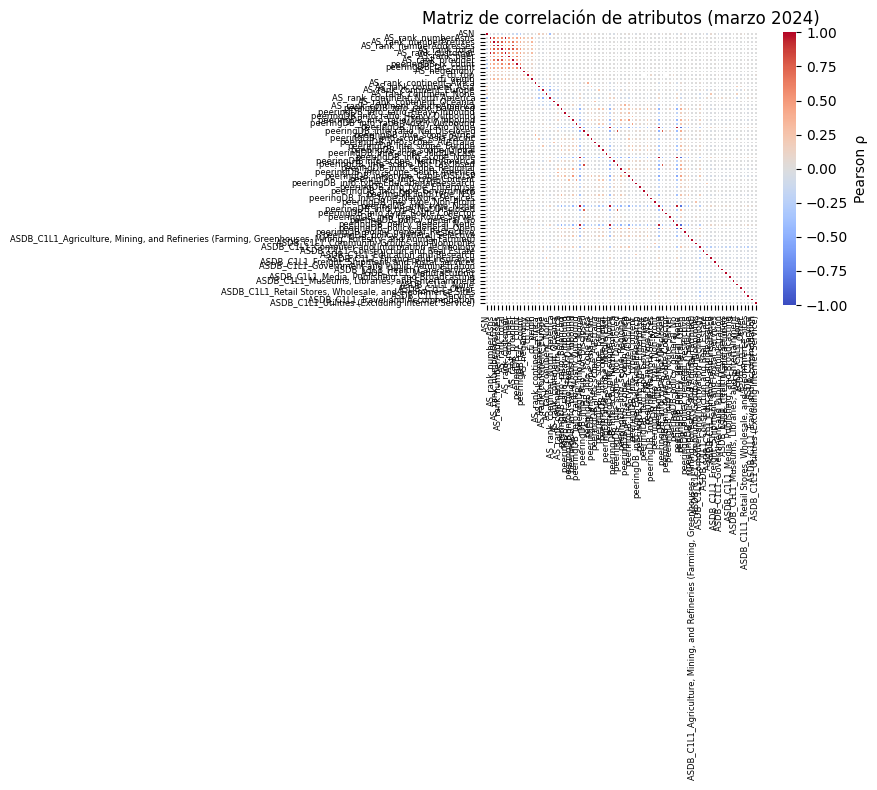

In [31]:
# 4) Dibuja (opción A: heatmap rápido en Seaborn)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_2022, cmap="coolwarm", vmin=-1, vmax=1,
            square=True, linewidths=.3,
            cbar_kws={"label": "Pearson ρ"},
            xticklabels=True, yticklabels=True)
plt.title("Matriz de correlación de atributos (marzo 2024)")
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()


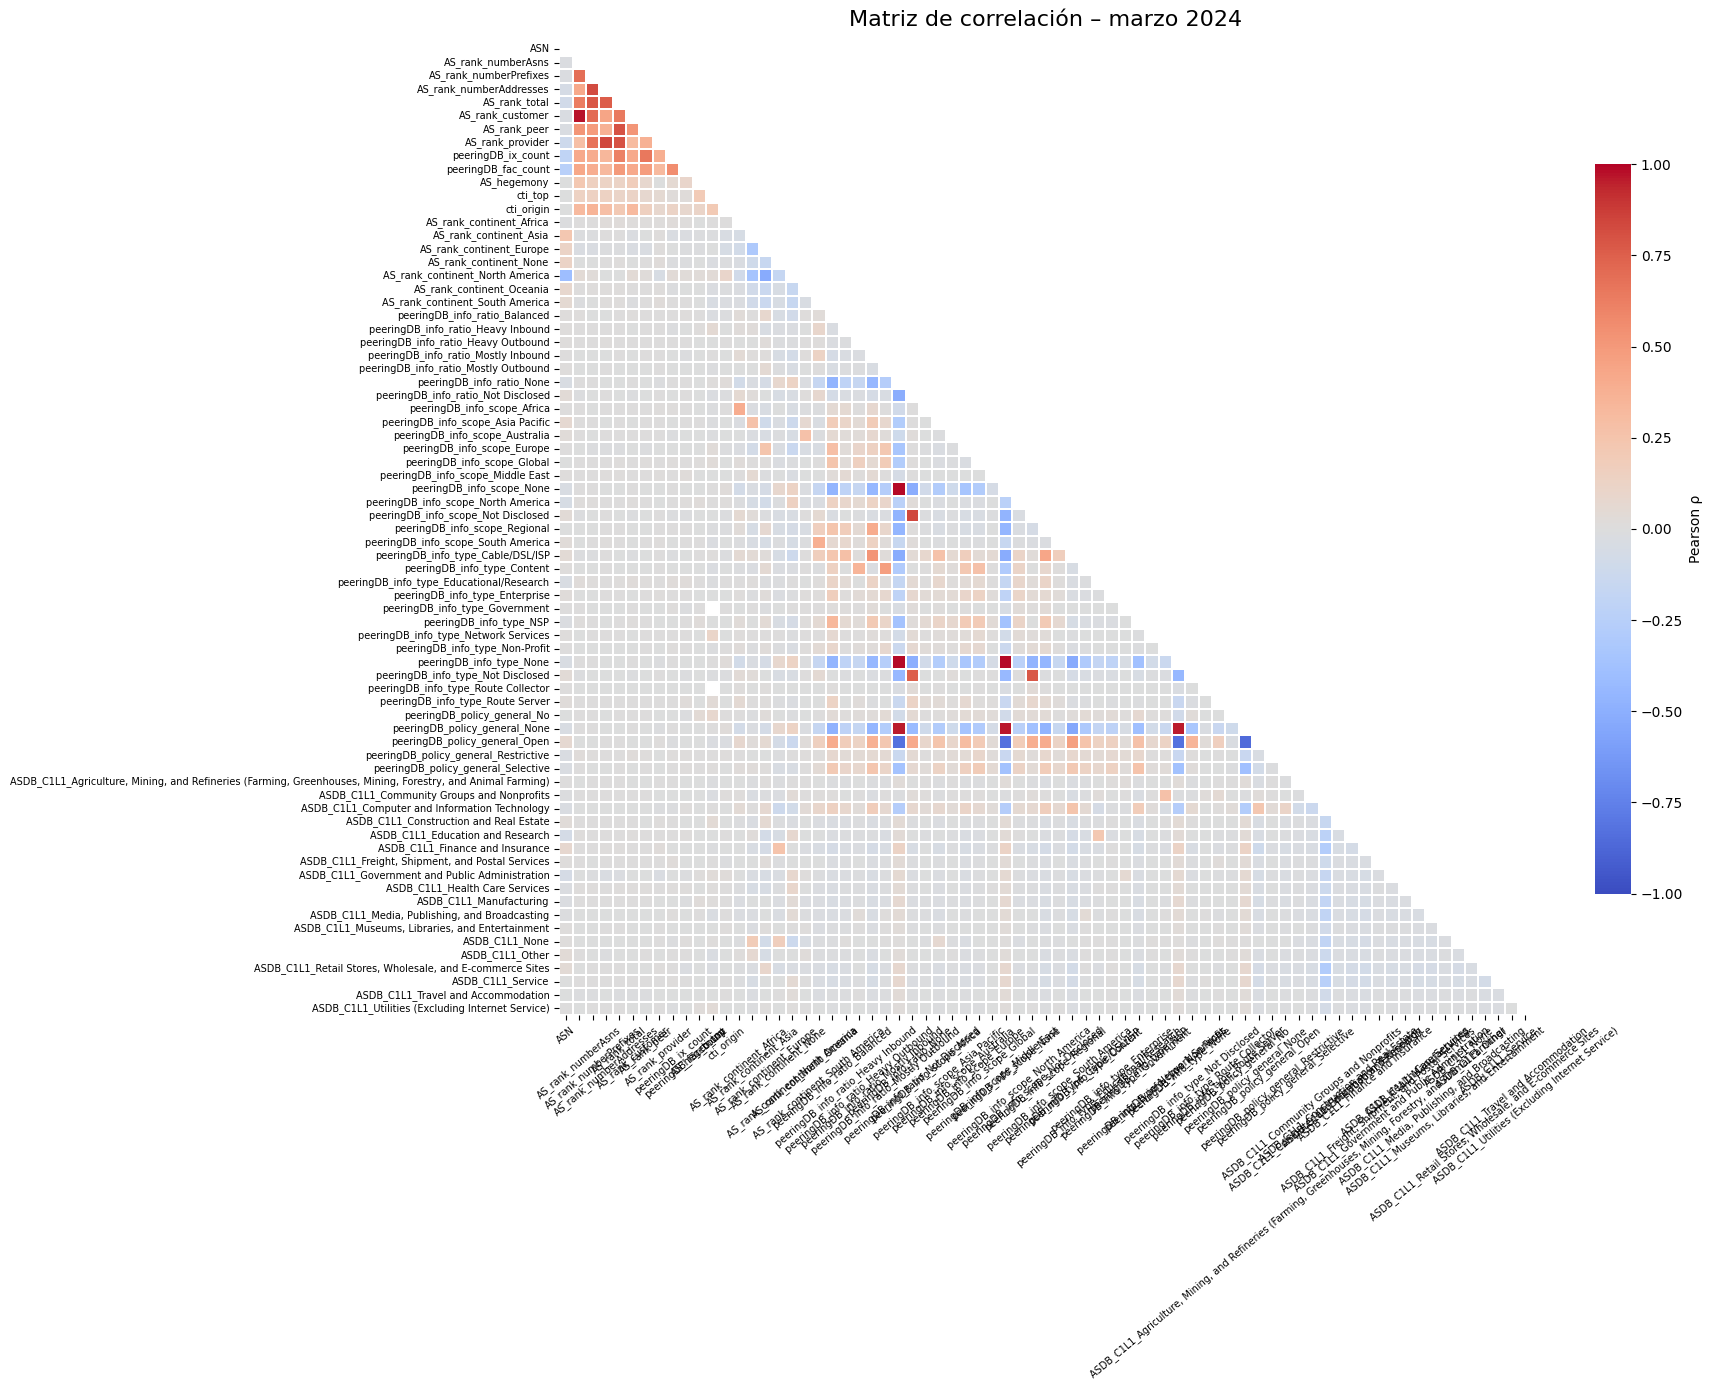

In [32]:

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

corr = df_2022.corr(method='pearson')

# -----  mascarilla para quedarnos con la parte inferior  -----
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(18, 14))          # ➊  tamaño grande
sns.heatmap(
    corr, mask=mask,
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    square=True, linewidths=.2,
    cbar_kws={'label': "Pearson ρ", 'shrink': .75},   # ➋  barra más pequeña
    xticklabels=True, yticklabels=True
)

ax.set_title("Matriz de correlación – marzo 2024", fontsize=16, pad=12)
ax.tick_params(axis='x', labelrotation=40, labelsize=7)  # ➌ etiquetas inclinadas
ax.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()


In [35]:
thr = 0.50
strong_pairs = (
    corr.where(np.tril(np.ones(corr.shape), -1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={'level_0':'Var1','level_1':'Var2',0:'rho'})
        .query('abs(rho) >= @thr')
        .sort_values('rho', ascending=False)
)

print("Pares con |ρ| ≥ 0.5\n", strong_pairs.head(15))


Pares con |ρ| ≥ 0.5
                                     Var1                                Var2  \
1067            peeringDB_info_type_None           peeringDB_info_scope_None   
553            peeringDB_info_scope_None           peeringDB_info_ratio_None   
1059            peeringDB_info_type_None           peeringDB_info_ratio_None   
11                      AS_rank_customer                  AS_rank_numberAsns   
1306       peeringDB_policy_general_None           peeringDB_info_scope_None   
1319       peeringDB_policy_general_None            peeringDB_info_type_None   
1298       peeringDB_policy_general_None           peeringDB_info_ratio_None   
621   peeringDB_info_scope_Not Disclosed  peeringDB_info_ratio_Not Disclosed   
24                      AS_rank_provider             AS_rank_numberAddresses   
5                AS_rank_numberAddresses              AS_rank_numberPrefixes   
19                          AS_rank_peer                       AS_rank_total   
25                 

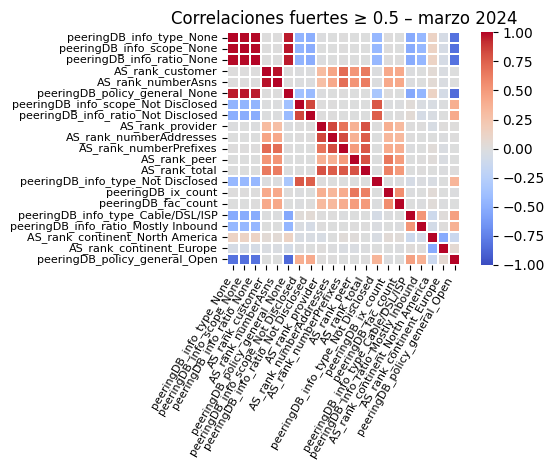

In [36]:
cols = pd.unique(strong_pairs[['Var1','Var2']].values.ravel())
sns.heatmap(corr.loc[cols, cols], cmap='coolwarm',
            vmin=-1, vmax=1, center=0,
            linewidths=.2, square=True)
plt.xticks(rotation=60, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.title("Correlaciones fuertes ≥ 0.5 – marzo 2024")
plt.tight_layout()
plt.show()


# Entender Embeddings

In [50]:
# Embeddings de mi ssd

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# attr = 'mis_attr'
# PATH = '/media/valentina/KINGSTON/TESIS/'

# # Mis embeddings de febrero
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GCN_mis_attr_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GraphSAGE_mis_attr_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GAT_mis_attr_febrero.pt'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GCN_mis_attr_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GraphSAGE_mis_attr_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GAT_mis_attr_febrero.pt'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# DepWalk
# attr = 'deepWalk'
# embeddings_path = '/media/valentina/KINGSTON/TESIS/data/embeddings/graphs2024/embeddings_deepWalk_febrero.pt' 

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# bgp2vec
# attr = 'bgp2vec'
# embeddings_path = '/media/valentina/KINGSTON/TESIS/data/embeddings/bgp2vec.word2vec'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# attr = 'grado_attr'
# PATH = '/media/valentina/KINGSTON/TESIS/'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_DotProduct_GAT_{attr}_febrero.pt'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_MLP_GAT_{attr}_febrero.pt'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Embeddings creados a partir de la prediccion pagaRank de 2024 nuestro

# attr = 'pagerank'
# PATH = '/media/valentina/KINGSTON/TESIS/'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GAT_{attr}_febrero.pt'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Embeddings creados a partir del grafo de grafo 2024 nuestro
attr = 'out_degree'
PATH = '/media/valentina/KINGSTON/TESIS/'

embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GAT_{attr}_febrero.pt'


# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# attr = 'closness'
# PATH = '/media/valentina/KINGSTON/TESIS/'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/full/embeddings_ribs_GAT_{attr}_febrero.pt'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Embeddings cracdo a partir Grafo julio 2022 de otro paper 
# attr = '2022_attr' 
# PATH = '/media/valentina/KINGSTON/TESIS/'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_DotProduct_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_DotProduct_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_DotProduct_GAT_{attr}_febrero.pt'

# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_MLP_GCN_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_MLP_GraphSAGE_{attr}_febrero.pt'
# embeddings_path = PATH + f'data/embeddings/graphs2024/febrero/2022julio/embeddings_ribs_MLP_GAT_{attr}_febrero.pt'

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////




embeddings_name = embeddings_path.split('/')[-1].split('.')[0]  # Nombre del archivo sin extensión
embeddings_pt = torch.load(embeddings_path)  # asegúrate que sea un tensor


## Visualización con t-SNE o PCA

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['P2P', 'C2P', 'P2C']

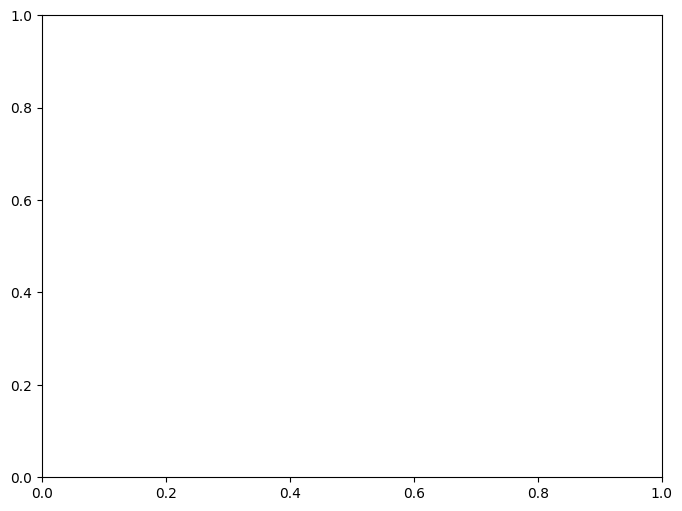

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels =['P2P','C2P','P2C']
# embeddings: tensor (N, d)
# labels: tensor o array con las clases (e.g., 0=P2P, 1=P2C, 2=C2P)
emb_np = embeddings_pt.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
emb_2d = tsne.fit_transform(emb_np)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title("Visualización de embeddings con t-SNE")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.colorbar(label="Clase de relación")
plt.tight_layout()
plt.show()

# Muestra si la GNN logró separar las clases.

# Si ves agrupaciones claras → embeddings útiles.


## Correlación entre embeddings y atributos

In [ ]:
import pandas as pd
import seaborn as sns

df_emb = pd.DataFrame(emb_np, columns=[f'emb_{i}' for i in range(emb_np.shape[1])])
df_attr = pd.read_csv("node_features_mio_febrero.csv")  # o el atributo que tengas

# Unir embeddings + atributos
df_full = pd.concat([df_emb, df_attr[['ix_count', 'fac_count', 'info_prefixes4', 'out_degree']]], axis=1)

corr = df_full.corr().loc[df_emb.columns, ['ix_count', 'fac_count', 'info_prefixes4', 'out_degree']]

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre dimensiones de embeddings y atributos")
plt.show()


#  Propiedades del grafo

## Distribución del grado

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

nx_g = gnn.dgl_graph.to_networkx()

degrees = [d for n, d in nx_g.degree()]
plt.hist(degrees, bins=100, log=True, color='steelblue')
plt.title("Distribución del grado de los nodos")
plt.xlabel("Grado"); plt.ylabel("Frecuencia (escala log)")
plt.tight_layout()
plt.show()


## Coeficiente de clustering

In [ ]:
cc = nx.average_clustering(nx_g.to_undirected())
print(f"Coeficiente de clustering promedio: {cc:.4f}")


    # El clustering muestra cuán "cerradas" son las relaciones entre vecinos de un nodo.

    # Un valor alto indica estructura más "social"; bajo, más jerárquica.


# Comparacion Aristas Grafo DGL y Archivo CAIDA AS Relationships

In [5]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import torch
from modules.gnn import GNN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import torch

def contar_aristas_coincidentes(g, caida_path, directed=True):
    # ---------- 1. Aristas del grafo -----------------------------------
    print('HOLAAAAAA')
    src, dst = g.all_edges()
    edges_g = torch.stack([src, dst], dim=1).tolist()
    if not directed:
        edges_g = [tuple(sorted(e)) for e in edges_g]
    set_grafo = set(map(tuple, edges_g))

    # ---------- 2. Aristas CAIDA (pandas + filtros) --------------------
    caida = (
        pd.read_csv(
            caida_path,
            sep="|",
            header=None,
            comment="#",        # descarta líneas que empiezan con #
            engine="python",    # parser más tolerante
            on_bad_lines="skip",# ignora filas mal formadas
            usecols=[0, 1, 2],  # solo las 3 primeras columnas
            names=["src", "dst", "rel"],
        )
        .dropna()              # elimina posibles NaNs
        .astype(int)           # convierte a enteros
    )

    # --- (opcional) filtrar por tipo de relación, p.ej. solo P2P -------
    # caida = caida[caida["rel"] == 0]

    caida_edges = (
        [tuple(sorted(e)) for e in caida[["src", "dst"]].values]
        if not directed
        else [tuple(e) for e in caida[["src", "dst"]].values]
    )
    set_caida = set(caida_edges)

    # ---------- 3. Intersección ---------------------------------------
    coincidencias = set_grafo & set_caida
    return len(coincidencias), len(set_grafo), len(set_caida)


In [ ]:
# Asumiendo que tu grafo vive en gnn.dgl_graph

# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'
INTERNETGRAPH_FILE = 'data/dgl_graphs/'
 
RELATIONSHIPS_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)
gnn.split_dataset_v0()

print(gnn.dgl_graph)




Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({0: 668740, 1: 154407, 2: 154407})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({0: 668740, 1: 154407, 2: 154407})
Training edges: 587020
Validation edges: 195600
Test edges: 194934
Graph(num_nodes=76415, num_edges=977554,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})


In [13]:
# Asumiendo que tu grafo vive en gnn.dgl_graph

# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'
INTERNETGRAPH_FILE = 'data/dgl_graphs/'
 
RELATIONSHIPS_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)
print(f"GRAFO: {gnn.dgl_graph}")
# print(f"Total de nodos en el grafo: {gnn.dgl_graph.num_nodes()}")
# print(f"Total de aristas en el grafo: {gnn.dgl_graph.num_edges()}")


matches, total_graph, total_caida = contar_aristas_coincidentes(
    gnn.dgl_graph,
    RELATIONSHIPS_FILE,
    directed=False   # o True según tu caso
)

print(f"Coinciden {matches} de {total_graph} aristas del grafo "
      f"({matches/total_graph:.2%})")

print(f"Coinciden {matches} de {total_caida} aristas del archivo CAIDA "
      f"({matches/total_caida:.2%})")


Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({0: 668740, 1: 154407, 2: 154407})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({0: 668740, 1: 154407, 2: 154407})
GRAFO: Graph(num_nodes=76415, num_edges=977554,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
HOLAAAAAA
Coinciden 72 de 488777 aristas del grafo (0.01%)
Coinciden 72 de 488777 aristas del archivo CAIDA (0.01%)


# conteo relaciones

In [2]:
import pandas as pd

CAIDA_PATH = '/media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
EDGES_PATHS = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/full/edges.csv'

In [2]:
ls /media/valentina/KINGSTON/TESIS/InternetGraphs2024/full/edges.csv

/media/valentina/KINGSTON/TESIS/InternetGraphs2024/full/edges.csv*


In [23]:
import pandas as pd

CAIDA_PATH = '/media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
TOR_LABELS = {'P2P': 0, 'C2P': 1, 'P2C': 2}

df_caida = pd.read_csv(
    CAIDA_PATH,
    sep='|',
    header=None,                   # el archivo no trae cabecera
    names=['src_id', 'dst_id', 'rel'],  # renómbralas como prefieras
    comment='#',                   # ignora comentarios
    compression='bz2',             # <- importante para .bz2
    dtype={'src_id': 'int32',
           'dst_id': 'int32',
           'rel':    'int8'},      # 0 ó -1 cabe en int8
    engine='c',                    # más rápido; cámbialo a 'python' si da problemas
    low_memory=False               # evita tipos mezclados
)
print("Filas totales:", len(df_caida))
# Mapea solo la dirección src→dst  (–1 ⇒ P2C, 0 ⇒ P2P)
df_caida['rel'] = df_caida['rel'].map({0: TOR_LABELS['P2P'],
                                           -1: TOR_LABELS['P2C']})

print("Filas totales:", len(df_caida))
print('Conteo', df_caida['rel'].value_counts())

# Duplica las inversas cuando rel == -1  ➜  C2P
inv = df_caida.query('rel == 2').copy()
inv[['src_id', 'dst_id']] = inv[['dst_id', 'src_id']]
inv['rel'] = TOR_LABELS['C2P']
print('Conteo', df_caida['rel'].value_counts())

df_caida = pd.concat([df_caida[['src_id', 'dst_id', 'rel']], inv], ignore_index=True)
df_caida.set_index(['src_id', 'dst_id'], inplace=True) 
print("Filas totales:", len(df_caida))
print(df_caida['rel'].value_counts())

df_caida

Filas totales: 488777
Filas totales: 488777
Conteo rel
0    334366
2    154411
Name: count, dtype: int64
Conteo rel
0    334366
2    154411
Name: count, dtype: int64
Filas totales: 643188
rel
0    334366
2    154411
1    154411
Name: count, dtype: int64


rel
src_id dst_id     
174    209       0
       286       0
       701       0
       1239      0
       1299      0
...            ...
136077 138826    1
140195 140127    1
60200  197216    1
3557   210765    1
30673  393672    1

[643188 rows x 1 columns]

In [19]:
EDGES_PATHS = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millon/edges.csv'
edges_dtypes = {'src_id': 'int32', 'dst_id': 'int32'}   # ajusta a tus nombres reales
CHUNK = 1_000_000

# Acumuladores
matches_list = []       # → DataFrames con coincidencias
label_counts = {0: 0, 1: 0, 2: 0}   # P2P / C2P / P2C

for chunk in pd.read_csv(EDGES_PATHS,
                         dtype=edges_dtypes,
                         usecols=['src_id', 'dst_id'],   # solo lo necesario
                         chunksize=CHUNK,
                         comment='#',              # si tu CSV lleva comentarios
                         low_memory=False):

    # Empareja dirección directa tal cual
    chunk_direct = chunk.merge(df_caida,
                               left_on=['src_id', 'dst_id'],
                               right_index=True,
                               how='inner')

    # Empareja dirección inversa (dst,src) para no perder coincidencias
    chunk_inv = (
        chunk.rename(columns={'src_id': 'dst_id', 'dst_id': 'src_id'})
             .merge(df_caida, left_on=['src_id', 'dst_id'],
                              right_index=True,
                              how='inner')
             .rename(columns={'src_id': 'dst_id', 'dst_id': 'src_id'})  # vuelve a nombres originales
    )

    chunk_matches = pd.concat([chunk_direct, chunk_inv], ignore_index=True)

    # Actualiza conteo de etiquetas
    vc = chunk_matches['rel'].value_counts().to_dict()
    for k, v in vc.items():
        label_counts[k] = label_counts.get(k, 0) + v

    matches_list.append(chunk_matches[['src_id', 'dst_id', 'rel']])

    print(f"Procesado bloque con {len(chunk)} edges → coincidencias {len(chunk_matches)}")

# Une todos los resultados
df_matches = pd.concat(matches_list, ignore_index=True)
print("\nResumen de coincidencias por tipo:", label_counts)
print("Total edges coincidentes:", len(df_matches))


Procesado bloque con 1000000 edges → coincidencias 1642400
Procesado bloque con 1000000 edges → coincidencias 1640650
Procesado bloque con 1000000 edges → coincidencias 1642572
Procesado bloque con 1000000 edges → coincidencias 1642928
Procesado bloque con 1000000 edges → coincidencias 1641164
Procesado bloque con 1000000 edges → coincidencias 1642636
Procesado bloque con 1000000 edges → coincidencias 1642528
Procesado bloque con 1000000 edges → coincidencias 1642856
Procesado bloque con 1000000 edges → coincidencias 1643462
Procesado bloque con 1000000 edges → coincidencias 1643138
Procesado bloque con 1000000 edges → coincidencias 1643476
Procesado bloque con 1000000 edges → coincidencias 1641656
Procesado bloque con 1000000 edges → coincidencias 1642364
Procesado bloque con 1000000 edges → coincidencias 1643110
Procesado bloque con 1000000 edges → coincidencias 1643338
Procesado bloque con 1000000 edges → coincidencias 1642960
Procesado bloque con 1000000 edges → coincidencias 16427

# Comparar febrero complto con CAIDA

In [24]:
EDGES_PATHS = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millon/edges.csv'


In [ ]:
import pandas as pd

EDGES_PATHS = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/1millon/edges.csv'
CHUNK = 1_000_000          # ajusta según tu memoria
seen = set()               # pares únicos ya vistos (tupla (src,dst))
dups_count = 0

for chunk in pd.read_csv(
        EDGES_PATHS,
        dtype={'src_id': 'int32', 'dst_id': 'int32'},
        usecols=['src_id', 'dst_id'],
        chunksize=CHUNK,
        comment='#'):

    # Convierte cada fila a tupla y cuenta duplicados dirigidos
    pairs = list(map(tuple, chunk[['src_id', 'dst_id']].to_numpy()))
    for p in pairs:
        if p in seen:
            dups_count += 1
        else:
            seen.add(p)

print("Duplicados dirigidos totales:", dups_count)
print("Aristas únicas dirigidas:", len(seen))


Duplicados dirigidos totales: 99184206
Aristas únicas dirigidas: 638460


: 